In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
# import cartopy.crs as ccrs
import matplotlib.patches as mpatches
#import hdbscan
# import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# import geojson
import json

In [2]:
# Reading the file with metrices
df_parking = gpd.read_file("F:/Berlin-DOP_2020/Processed images_new/parking_dist.gpkg", layer="parking_disolved_withdata")

In [3]:
# Renaming the column heading
df_parking = df_parking.rename(columns={'True or False': 'True_or_False'})
df_parking.loc[df_parking.True_or_False == "true", 'True_or_False'] = 1
df_parking.loc[df_parking.True_or_False == "false", 'True_or_False'] = 0
df_parking = pd.DataFrame(df_parking[['parking_area_m2', 'nearest_geometry_dis', 'True_or_False']])

In [4]:
df_parking['True_or_False'] = df_parking['True_or_False'].astype(str)

In [5]:
X = df_parking.iloc[:,:-1]

In [6]:
y = df_parking["True_or_False"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)

In [8]:
reg = LogisticRegression(max_iter= 300)
reg.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [9]:
y_pred = reg.predict(X_test)

<Figure size 720x360 with 0 Axes>

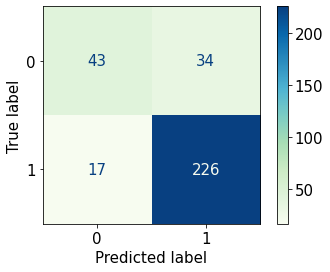

<Figure size 720x360 with 0 Axes>

In [11]:
confusion_matrix = metrics.plot_confusion_matrix(reg, X_test, y_test, cmap = "GnBu")
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (10,5))

In [11]:
print("Accuracy", metrics.accuracy_score(y_test, y_pred))

Accuracy 0.840625


In [12]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63        77
           1       0.87      0.93      0.90       243

    accuracy                           0.84       320
   macro avg       0.79      0.74      0.76       320
weighted avg       0.83      0.84      0.83       320



In [13]:
y_pred = [int(y_pred) for y_pred in y_pred]
y_test =y_test.astype(int).array

AUC: 0.81


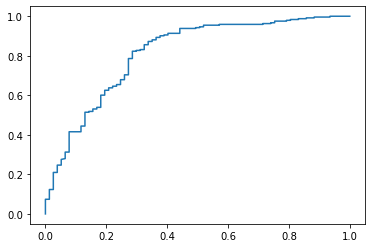

In [14]:
# ROC curve and AUC
y_pred_prob = reg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve (y_test, y_pred_prob)
plt.plot(fpr, tpr)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print("AUC:", round(auc,2))

In [15]:
# Reading the file with predictions
df_pred_new = gpd.read_file("F:/Berlin-DOP_2020/Processed images_new/Final/Predic_dissolved.geojson",crs='EPSG:25833')

In [16]:
# Renaming the column heading
df_pred = pd.DataFrame(df_pred_new[['parking_area_m2', 'nearest_geometry_dis']])

In [17]:
df_pred

,parking_area_m2,nearest_geometry_dis
0,48.033860,2.954590
1,48.033860,2.839877
2,48.033860,0.258309
3,48.033860,0.258309
4,14.047920,23.613326
...,...,...
8971,10.368876,34.054367
8972,34.782663,14.815357
8973,33.143099,10.094998
8974,23.646757,24.441951


In [18]:
y_pred_pred = reg.predict(df_pred)

In [19]:
#df_pred_new.to_file("F:/Berlin-DOP_2020/Processed images_new/Final/Processed_dissolved.geojson", crs='EPSG:25833')

In [20]:
with open("F:/Berlin-DOP_2020/Processed images_new/Final/Processed_dissolved_1.geojson", 'a') as f:
    geojson.dump(df_pred_new, f)

In [21]:
df_pred_new['True_or_False']= y_pred_pred
df_pred_new.loc[df_pred_new.True_or_False == "1", 'True_or_False'] = "true"
df_pred_new.loc[df_pred_new.True_or_False == "0", 'True_or_False'] = "false"

In [22]:
# Merging with original dataframe
df_original = gpd.read_file("F:/Berlin-DOP_2020/Processed images_new/Predictions.geojson", crs='EPSG:25833')

In [23]:
df_original

,id,label,geometry
0,1,PK-space-occupied,"MULTIPOLYGON (((391033.600 5824044.550, 391034..."
1,2,PK-space-occupied,"MULTIPOLYGON (((391038.600 5824010.850, 391039..."
2,3,PK-space-occupied,"MULTIPOLYGON (((391018.550 5824050.000, 391018..."
3,4,PK-space-occupied,"MULTIPOLYGON (((391032.100 5824035.850, 391032..."
4,5,PK-space-occupied,"MULTIPOLYGON (((391031.700 5824035.850, 391031..."
...,...,...,...
8974,8980,PK-space-occupied,"MULTIPOLYGON (((392978.800 5824894.250, 392979..."
8975,8981,PK-space-occupied,"MULTIPOLYGON (((392994.200 5824927.750, 392994..."
8976,8982,PK-space-occupied,"MULTIPOLYGON (((392993.700 5824932.450, 392994..."
8977,8983,PK-space-occupied,"MULTIPOLYGON (((392958.900 5824907.950, 392959..."


In [24]:
df_pred_new

,id,label,parking_area_m2,nearest_geometry_dis,geometry,True_or_False
0,8608,PK-space-occupied,48.033860,2.954590,"POLYGON ((392980.300 5820999.150, 392976.000 5...",true
1,8606,PK-space-empty,48.033860,2.839877,"POLYGON ((392980.300 5820999.150, 392976.000 5...",true
2,8607,PK-space-occupied,48.033860,0.258309,"POLYGON ((392980.300 5820999.150, 392976.000 5...",true
3,8603,PK-space-occupied,48.033860,0.258309,"POLYGON ((392980.300 5820999.150, 392976.000 5...",true
4,1968,PK-space-occupied,14.047920,23.613326,"POLYGON ((392135.900 5820999.150, 392134.800 5...",false
...,...,...,...,...,...,...
8971,6032,PK-space-occupied,10.368876,34.054367,"POLYGON ((392624.236 5824997.164, 392623.636 5...",false
8972,5135,PK-space-occupied,34.782663,14.815357,"POLYGON ((392538.400 5824994.450, 392537.600 5...",true
8973,3075,PK-space-occupied,33.143099,10.094998,"POLYGON ((392243.850 5824997.258, 392243.831 5...",true
8974,521,PK-space-occupied,23.646757,24.441951,"POLYGON ((391527.161 5825000.737, 391529.438 5...",false


In [25]:
Merged_df = df_original.merge(df_pred_new, on='id', how='inner')

In [26]:
Merged_df = Merged_df.drop(['geometry_y'], axis = 1)

In [27]:
Merged_gdf = gpd.GeoDataFrame(Merged_df, geometry="geometry_x", crs='EPSG:25833')

In [28]:
Merged_gdf

,id,label_x,geometry_x,label_y,parking_area_m2,nearest_geometry_dis,True_or_False
0,1,PK-space-occupied,"MULTIPOLYGON (((391033.600 5824044.550, 391034...",PK-space-occupied,27.363242,9.398797,true
1,2,PK-space-occupied,"MULTIPOLYGON (((391038.600 5824010.850, 391039...",PK-space-occupied,30.175678,26.399800,false
2,3,PK-space-occupied,"MULTIPOLYGON (((391018.550 5824050.000, 391018...",PK-space-occupied,91.584665,10.902318,true
3,4,PK-space-occupied,"MULTIPOLYGON (((391032.100 5824035.850, 391032...",PK-space-occupied,41.985958,1.126644,true
4,5,PK-space-occupied,"MULTIPOLYGON (((391031.700 5824035.850, 391031...",PK-space-occupied,41.985958,1.126644,true
...,...,...,...,...,...,...,...
8971,8980,PK-space-occupied,"MULTIPOLYGON (((392978.800 5824894.250, 392979...",PK-space-occupied,12.731626,21.742114,false
8972,8981,PK-space-occupied,"MULTIPOLYGON (((392994.200 5824927.750, 392994...",PK-space-occupied,66.990136,2.433225,true
8973,8982,PK-space-occupied,"MULTIPOLYGON (((392993.700 5824932.450, 392994...",PK-space-occupied,66.990136,3.853211,true
8974,8983,PK-space-occupied,"MULTIPOLYGON (((392958.900 5824907.950, 392959...",PK-space-occupied,32.571427,21.742114,false


In [29]:
with open("F:/Berlin-DOP_2020/Processed images_new/Final/Final_dataframe_1.geojson", 'a') as f:
    geojson.dump(Merged_gdf, f)

In [30]:
#Merged_gdf.to_file("F:/Berlin-DOP_2020/Processed images_new/Final/Final_dataframe.geojson")

In [31]:
df_true_only = Merged_gdf.loc[Merged_gdf["True_or_False"] == "true"]

In [32]:
#df_true_only.to_file("F:/Berlin-DOP_2020/Processed images_new/Final/True_Only.geojson")

In [33]:
with open("F:/Berlin-DOP_2020/Processed images_new/Final/True_Only_1.geojson", 'a') as f:
    geojson.dump(df_true_only, f)